# Soil moisture individual global figures for the multipanel Figure 1 of Chapter 12

## Produces the figures for:
- 20412060 ssp585 - historical (mid-21st century)
- 20812100 ssp585 - historical (late-21st century)
- 20812100 ssp126 - historical (late-21st century)
- the colorbar

In [1]:
# -- Preparing the files

# -- Select the periods by scenario
# -- Compute annual sums
# -- Split the annual files
# -- Using CliMAF:
# --   - compute the individual differences
# --   - compute the ensemble statistics
# --   - start the plot of the ensemble median
# --   - code model agreement

In [1]:
import os, glob
import xarray as xr
from IPython.display import Image
from PIL import Image as PILImage

In [2]:
variable = 'mrso'

## The input files are provided by Mathias Hauser
One file per model / experiment, with the whole period covered

Need to select the periods

### Import the CliMAF library to do the pretreatments (https://climaf.readthedocs.io/en/master/)

In [3]:
from climaf.api import *

CliMAF version = 1.2.13


CliMAF install => /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post
python => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/python
---
Required softwares to run CliMAF => you are using the following versions/installations:
ncl 6.6.2 => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncl
cdo 1.9.6 => /opt/nco/1.9/bin/cdo
nco (ncks) 4.5.2 => /opt/nco-4.5.2/bin/ncks
ncdump fichier => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncdump
Check stamping requirements
nco (ncatted) found -> /opt/nco-4.5.2/bin/ncatted
convert found -> /usr/bin/convert
pdftk found -> /usr/bin/pdftk
exiv2 found -> /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post/bin/exiv2
---


Cache directory set to : /data/jservon/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/jservon/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
Available macros read from ~/.climaf.macros are : []


### Declare the access to the archive

In [4]:
#pattern = '/data/jservon/IPCC/spi/individual_models/'+CMIP+'/'+CMIP+'_${experiment}_${variable}_${period}_${member}.nc'
pattern = '/data/jservon/IPCC/mrso/data.iac.ethz.ch/IPCC_AR6/for_ch12/cmip6/mrso/sm_annmean_regrid_g010a/sm_annmean_regrid_g010a_${variable}_Lmon_${model}_${experiment}_${realization}_gn.nc'
cproject('mrso_individual_models_cmip6_ch12','experiment','model','realization',('variable',variable), ensemble=['model'], separator='%')
dataloc(project='mrso_individual_models_cmip6_ch12', url=pattern)    

<climaf.dataloc.dataloc instance at 0x2af106caec20>

## Work on the individual models:
- create scenario and baseline ensembles => select common models
- compute annual sums
- compute climatologies
- compute differences

In [5]:
exp_list = [
    dict(experiment='ssp585',
         period = '2041-2060'),
    dict(experiment='ssp585',
         period = '2081-2100'),
    dict(experiment='ssp126',
         period = '2081-2100'),
]

# -- Create ensemble for historical baseline
# 1. Initial request to list all the models
req_baseline_dict = dict(project='mrso_individual_models_cmip6_ch12',
                         experiment = 'historical',
                         period = '1995-2004',
                         realization = '*'
                        )
req_baseline = ds(model='*', **req_baseline_dict)
# 2. Build the ensemble by hand to deal with the realizations
ens_baseline_dict = dict()
for model in req_baseline.explore('choices')['model']:
    ens_baseline_dict[model] = ds(model=model, **req_baseline_dict).explore('resolve')
ens_baseline = cens(ens_baseline_dict)

# -- Loop on the scenarios
ens_diff = dict()
for exp in exp_list:
    #
    # -- Experiment and period
    experiment = exp['experiment']
    period = exp['period']
    
    # -- Create ensemble object for the scenario
    # 1. Initial request to list all the models
    req_exp_dict = dict(project='mrso_individual_models_cmip6_ch12',
                        experiment = experiment,
                        period = period,
                        realization = '*'
                       )
    req_exp = ds(model='*', **req_exp_dict)
    # 2. Build the ensemble by hand to deal with the realizations
    ens_exp_dict = dict()
    for model in req_exp.explore('choices')['model']:
        ens_exp_dict[model] = ds(model=model, **req_exp_dict).explore('resolve')
    ens_exp = cens(ens_exp_dict)
    
    # -- Extract common members
    wens_baseline, wens_exp = ensemble_intersection([ens_baseline, ens_exp])
    #    
    # -- Climatologies
    clim_baseline = clim_average(wens_baseline, 'ANM')
    clim_exp      = clim_average(wens_exp, 'ANM')
    
    # -- Changes = Scenario minus baselines
    diff_exp_baseline = fmul( fdiv(fsub(clim_exp, clim_baseline), clim_baseline), 100)
    ens_diff[experiment+'_'+period] = diff_exp_baseline

In [6]:
pp_colorbar = dict(proj   = 'Robinson',
                   min = -5, max=5, delta=0.5,
                   color  = 'MPL_BrBG',#NCV_blu_red',
                   focus = 'land',
                   tiMainFontHeightF=0.03,
                   gsnStringFontHeightF=0.02,
                   gsnRightString='', gsnLeftString=''
                  )

In [7]:
pp = pp_colorbar.copy()
pp.update(
    dict(options='gsnAddCyclic=True|lbLabelBarOn=False|lbBoxEndCapStyle=TriangleBothEnds|mpGridAndLimbOn=True|mpGridLineColor=-1')
)         

In [7]:
clog('critical')

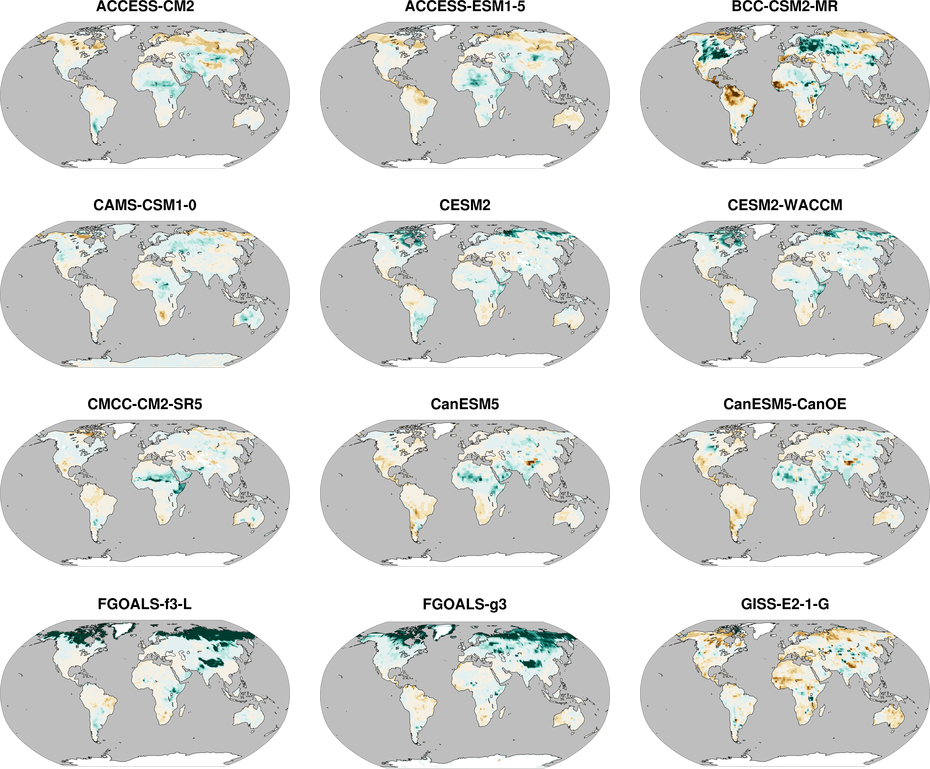

In [12]:
# -- Plot the individual models
wfuture = 'ssp585_2081-2100'
iplot_members(ens_diff[wfuture], N=1, **pp)

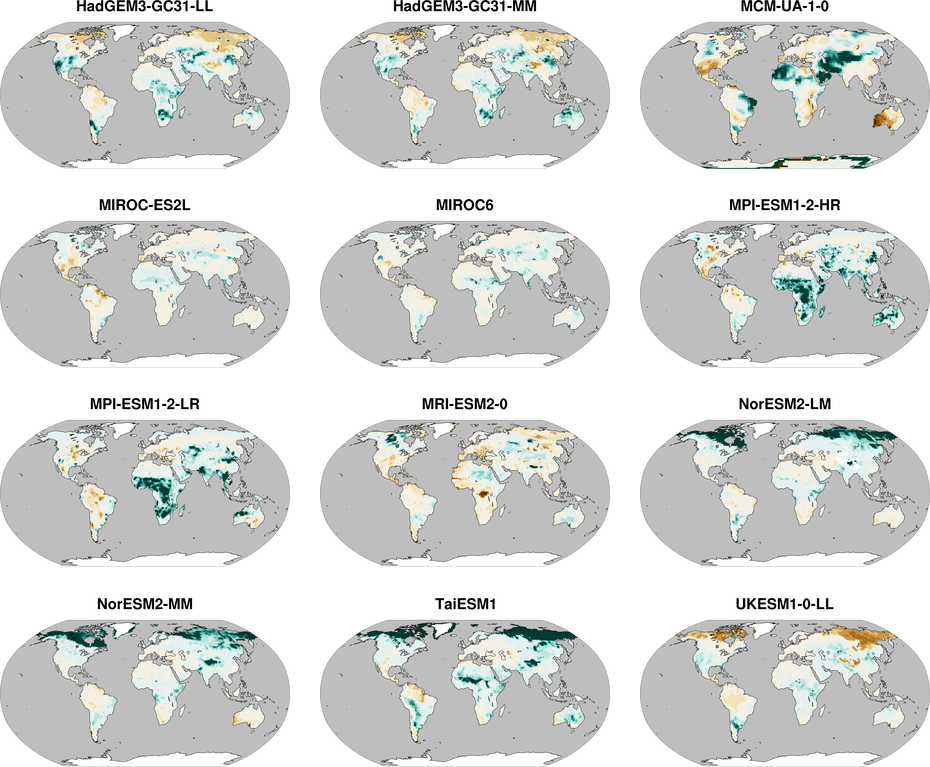

In [13]:
iplot_members(ens_diff[wfuture], N=2, **pp)

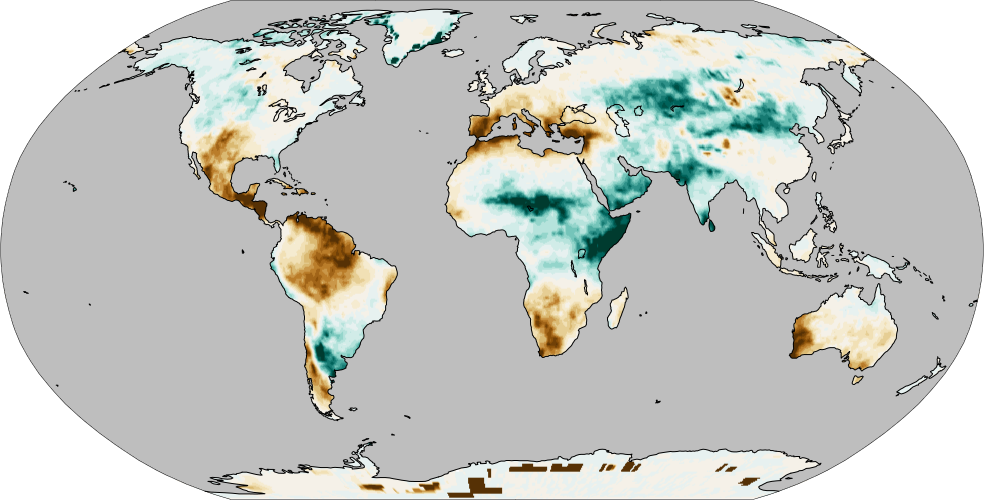

In [19]:
#iplot_members(ens_diff[wfuture], N=3, **pp)
implot(ccdo_ens(ens_diff[wfuture], operator='enspctl,50'),**pp)

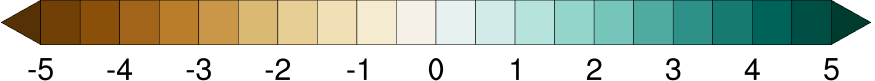

In [8]:
# -- Colorbar
def extract_labelbar(figure_file,labelbar_file) :
    #import PIL
    im = PILImage.open(figure_file)
    #box=(left, upper, right, lower).
    im_crop = im.crop((55, 563, 930, 644))
    im_crop.save(labelbar_file, quality=95)

# -- Base plot for the colorbar
wfuture = 'ssp585_2081-2100'
plot_4colorbar = plot(ens_diff[wfuture][ens_diff[wfuture].keys()[2]],
                      options='lbOrientation=horizontal|lbLabelFontHeightF=0.018|lbBoxEndCapStyle=TriangleBothEnds',
                      **pp_colorbar)

# -- color bar file
colorbar_file = '/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/'+variable+'_colorbar.png'

# -- Extract the colorbar
extract_labelbar(cfile(plot_4colorbar),colorbar_file)

Image(colorbar_file)

In [9]:
plot_4colorbar = plot(ens_diff[wfuture][ens_diff[wfuture].keys()[2]],
                      options='lbOrientation=horizontal|lbLabelFontHeightF=0.018|lbBoxEndCapStyle=TriangleBothEnds',
                      format='pdf',
                      **pp_colorbar)

# -- color bar file
colorbar_file = '/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/'+variable+'_colorbar.pdf'

cfile(cpdfcrop(plot_4colorbar), target=colorbar_file)

'/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/mrso_colorbar.pdf'

## Ensemble statistics

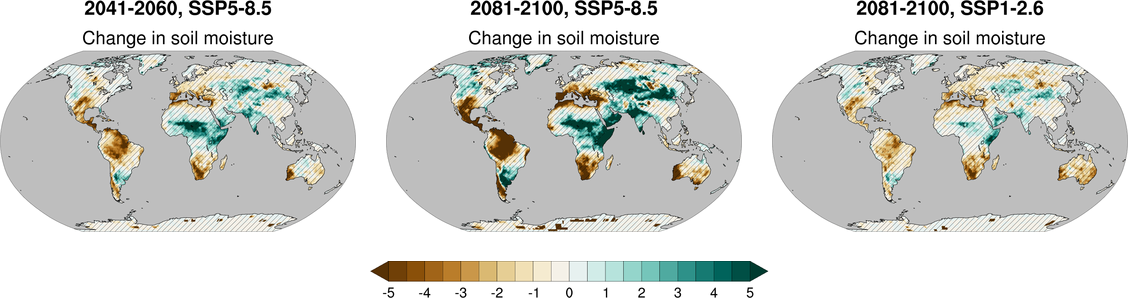

In [15]:
#for perc_agreement in ['80']:
perc_agreement = '80'
signif90_dict = dict()
outdatadir = '/home/jservon/Chapter12_IPCC/data/Figure_12.4/SM/'
for exp in exp_list:
    # -- Experiment and period
    experiment = exp['experiment']
    period = exp['period']
    wfuture = experiment+'_'+period

    # -- Mask of models with
    ens_mask_pos = ccdo(ens_diff[wfuture], operator='gtc,0')
    ens_mask_neg = ccdo(ens_diff[wfuture], operator='ltc,0')
    ens_mask_zero = ccdo(ens_diff[wfuture], operator='eqc,0')

    perc_ens_pos = fmul( fdiv( ccdo_ens(ens_mask_pos, operator='enssum'), len(ens_diff[wfuture]) ), 100 )
    perc_ens_neg = fmul( fdiv( ccdo_ens(ens_mask_neg, operator='enssum'), len(ens_diff[wfuture]) ), 100 )
    perc_ens_zero = fmul( fdiv( ccdo_ens(ens_mask_zero, operator='enssum'), len(ens_diff[wfuture]) ), 100 )

    # -- Signif90
    signif90_pos = ccdo(perc_ens_pos, operator='gtc,'+perc_agreement)
    signif90_neg = ccdo(perc_ens_neg, operator='gtc,'+perc_agreement)
    signif90_zero = ccdo(perc_ens_zero, operator='gtc,'+perc_agreement)
    signif90_dict[wfuture] = fmul( fadd( fadd(signif90_pos, signif90_neg), signif90_zero), -1)
    if wfuture=='ssp126_2081-2100':
        panel = 'panel_j'
    if wfuture=='ssp585_2041-2060':
        panel = 'panel_k'
    if wfuture=='ssp585_2081-2100':
        panel = 'panel_l'
    mask_agreement_name = outdatadir + 'mask_'+perc_agreement+'perc-agreement_SM_'+panel+'_'+wfuture+'_minus_baseline.nc'
    cfile(signif90_dict[wfuture], target=mask_agreement_name)
    cmd = 'ncatted -O -a comment,global,o,c,"This file is used for the hatching of '+panel+' of figure 12.4 - Chapter 12" '+mask_agreement_name
    os.system(cmd)



CMIP='CMIP6'

outdir = '/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/'

if CMIP=='CMIP6': wfuture = 'ssp585_2041-2060'
if CMIP=='CMIP5': wfuture = 'rcp85_2041-2060'
ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')

pp['tiMainFontHeightF'] = 0.032
pp['gsnStringFontHeightF'] = 0.03

wfuture = 'ssp585_2041-2060'
#ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + 'SM_panel_k_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel k of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p1 = plot(ensmedian_field,
          signif90_dict[wfuture],
          shade_above = -0.99999,
          shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
          gsnCenterString = 'Change in soil moisture',
          #gsnLeftString = '(j)',
          title = '2041-2060, SSP5-8.5',
          **pp
         )
cfile(p1, target = outdir + 'panel_k_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')

if CMIP=='CMIP6': wfuture = 'ssp585_2081-2100'
if CMIP=='CMIP5': wfuture = 'rcp85_2081-2100'
#ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + 'SM_panel_l_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel l of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p2 = plot(ensmedian_field,
          signif90_dict[wfuture],
          shade_above = -0.99999,
          shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
          gsnCenterString = 'Change in soil moisture',
          #gsnLeftString = '(k)',
          title = '2081-2100, SSP5-8.5',
          **pp
         )
cfile(p2, target = outdir + 'panel_k_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')

if CMIP=='CMIP6': wfuture = 'ssp126_2081-2100'
if CMIP=='CMIP5': wfuture = 'rcp26_2081-2100'
#ensmedian_field = ccdo_ens(regridn(ens_diff[wfuture],cdogrid='r360x180'), operator='enspctl,50')
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + 'SM_panel_j_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel j of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p3 = plot(ensmedian_field,
          signif90_dict[wfuture],
          shade_above = -0.99999,
          shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
          gsnCenterString = 'Change in soil moisture',
          #gsnLeftString = '(l)',
          title = '2081-2100, SSP1-2.6',
          **pp
         )
cfile(p3, target = outdir + 'panel_j_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.png')

mp = cpage(fig_lines=[[p1,p2,p3]],
            insert=colorbar_file,
            insert_width=400, page_width=1200
          )
#cdrop(mp)
iplot(mp)

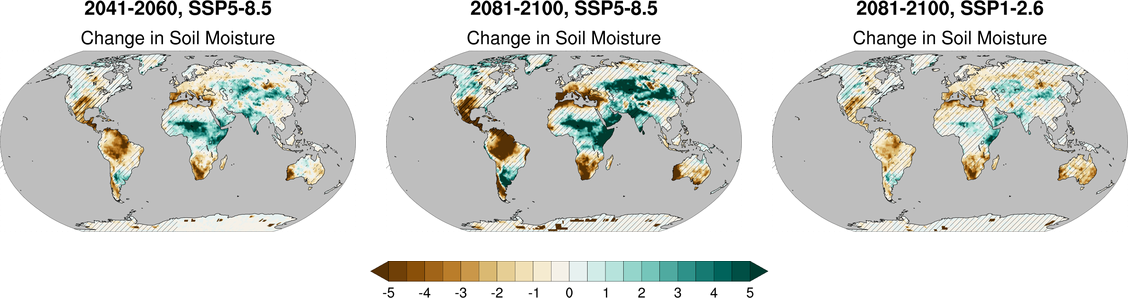

In [11]:
iplot(mp)

In [28]:
outdir + variable+'_'+wfuture+'.png'

'/home/jservon/Chapter12_IPCC/figs/global_figure_12.4/mrso_ssp126_2081-2100.png'

## Pdf versions

In [ ]:
wfuture = 'ssp585_2041-2060'
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + 'SM_panel_k_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel k of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p1 = plot(ensmedian_field,
            signif90_dict[wfuture],
            shade_above = -0.99999,
            shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
            gsnCenterString = 'Change in soil moisture',
            format='pdf',
            title = '2041-2060, SSP5-8.5',
            **pp
            )
cfile(cpdfcrop(p1), target = outdir + 'panel_k_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')

if CMIP=='CMIP6': wfuture = 'ssp585_2081-2100'
if CMIP=='CMIP5': wfuture = 'rcp85_2081-2100'
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + 'SM_panel_l_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel l of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p2 = plot(ensmedian_field,
            signif90_dict[wfuture],
            shade_above = -0.99999,
            shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
            gsnCenterString = 'Change in soil moisture',
            format='pdf',
            title = '2081-2100, SSP5-8.5',
            **pp
            )
cfile(cpdfcrop(p2), target = outdir + 'panel_k_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')

if CMIP=='CMIP6': wfuture = 'ssp126_2081-2100'
if CMIP=='CMIP5': wfuture = 'rcp26_2081-2100'
ensmedian_field = ccdo_ens(ens_diff[wfuture], operator='enspctl,50')
ensmedian_filename = outdatadir + 'SM_panel_j_'+wfuture+'_minus_baseline.nc'
cmd = 'ncatted -O -a comment,global,o,c,"This file is used for panel j of figure 12.4 - Chapter 12" '+ensmedian_filename
cfile(ensmedian_field, target=ensmedian_filename)
os.system(cmd)
p3 = plot(ensmedian_field,
            signif90_dict[wfuture],
            shade_above = -0.99999,
            shading_options='gsnShadeHigh=3|gsnShadeFillScaleF=1.0',
            gsnCenterString = 'Change in soil moisture',
            format='pdf',
            title = '2081-2100, SSP1-2.6',
            **pp
            )
cfile(cpdfcrop(p3), target = outdir + 'panel_k_' + variable+'_'+wfuture+'_'+perc_agreement+'perc-agreement.pdf')
